In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
#allows to print the dataframe nicely
from IPython.core import display as ICD

In [2]:
# import additional packages to insepct data
import pandas as pd
import os 
import random 
from zipfile import ZipFile

In [3]:
# import helping functions
from proj1_helpers import load_csv_data

In [4]:
# import files
data_folder='./data/'
zip_file = ZipFile(data_folder+'all.zip')
# zip file creates a list of files with certain properties
zip_file.infolist()

[<ZipInfo filename='train.csv' compress_type=deflate file_size=48103379 compress_size=17670847>,
 <ZipInfo filename='test.csv' compress_type=deflate file_size=109335584 compress_size=40089137>,
 <ZipInfo filename='sample-submission.csv' compress_type=deflate file_size=5682394 compress_size=1263762>]

Training set, Validation set and Test set.

In [81]:
# now we want to access the 'filename' property in the zipfile variable
# and we create a dictionary of dataframe
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}
df_train=dfs['train.csv']
df_test=dfs['test.csv']
df_sample_submission=dfs['sample-submission.csv']

variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by  the physicists of ATLAS
it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables

array(['Id', 'Prediction', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt',
       'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta',
       'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
       'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',
       'PRI_jet_all_pt'], dtype=object)

211885

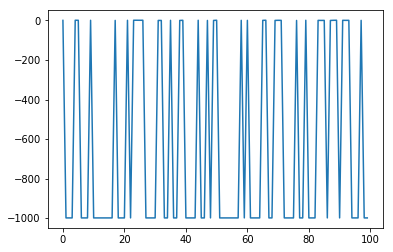

In [112]:
ICD.display(df_train.columns.values)

# take out negative values being -999
df_train['DER_mass_MMC'][df_train['DER_mass_MMC'].apply(lambda x: x<0)].unique()

df_train=df_train.drop(df_train.index[df_train['DER_mass_MMC'].apply(lambda x: x<0)])
df_train['DER_mass_transverse_met_lep'].describe()
df_train['DER_mass_vis'].describe()
df_train['DER_pt_h'].describe()

# changing almost consistently between zero and -1000
df_train['DER_deltaeta_jet_jet'].describe()
# plt.plot(range(100),df_train['DER_deltaeta_jet_jet'][:100])

# changing almost consistently between zero and -1000
df_train['DER_mass_jet_jet'].describe()
# plt.plot(range(100),df_train['DER_mass_jet_jet'][:100])

# changing almost consistently between zero and -1000
df_train['DER_prodeta_jet_jet'].describe()
# plt.plot(range(100),df_train['DER_prodeta_jet_jet'][:100])

df_train['DER_deltar_tau_lep'].describe()
# plt.plot(range(100),df_train['DER_deltar_tau_lep'][:100])

# remove outlier
df_train['DER_pt_tot'].describe()
df_train=df_train.drop(df_train.index[df_train['DER_pt_tot']>2800])
# plt.plot(range(df_train.shape[0]),df_train['DER_pt_tot'])

# ok variation
df_train['DER_sum_pt'].describe()
# plt.plot(range(df_train.shape[0]),df_train['DER_sum_pt'])

# ok variation
df_train['DER_pt_ratio_lep_tau'].describe()
# plt.plot(range(df_train.shape[0]),df_train['DER_pt_ratio_lep_tau'])

# oscillation between max of 1.41 and -1.41
df_train['DER_met_phi_centrality'].describe()
# plt.plot(range(20),df_train['DER_met_phi_centrality'][:20])

# changing almost consistently between zero and -1000
df_train['DER_lep_eta_centrality'].describe()
plt.plot(range(100),df_train['DER_lep_eta_centrality'][:100])

len(df_train[df_train['DER_lep_eta_centrality']==-999.0])
len(df_train)

In [8]:
yb, input_data, ids=np.array(df_train['Prediction']), np.array(df_train.iloc[:,2:]), np.array(df_train['Id'])

In [9]:
ICD.display(input_data)


array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

In [10]:
# transform yb into numerical values
yb[np.where(yb=='b')] = -1
yb[np.where(yb=='s')] = 1
input_data.shape

(250000, 30)

Build Polynomial

In [50]:
# from helpers import polynomial_regression
from helpers import build_poly
degree=2
tx=build_poly(input_data[:3,:3], degree)
#you can select the feature space by slicing the array
ICD.display(tx[[0,1,2]])

#trial of slicing without for loop
# ICD.display(np.transpose(tx[[0,1,2]],(0,2,1)))
a = np.tensordot(np.transpose(tx[[0,1]],(0,2,1)),(tx[[0,1]]),axes=([2],[2]))
b = tx[[0,1,2]].T.dot(yb[[0,1,2]])

# ICD.display(tx.shape)
np.transpose(tx,(0,2,1)).shape
ICD. display(a)

array([[[ 1.00000000e+00,  1.38470000e+02,  1.91739409e+04],
        [ 1.00000000e+00,  1.60937000e+02,  2.59007180e+04],
        [ 1.00000000e+00, -9.99000000e+02,  9.98001000e+05]],

       [[ 1.00000000e+00,  5.16550000e+01,  2.66823903e+03],
        [ 1.00000000e+00,  6.87680000e+01,  4.72903782e+03],
        [ 1.00000000e+00,  1.62172000e+02,  2.62997576e+04]],

       [[ 1.00000000e+00,  9.78270000e+01,  9.57012193e+03],
        [ 1.00000000e+00,  1.03235000e+02,  1.06574652e+04],
        [ 1.00000000e+00,  1.25953000e+02,  1.58641582e+04]]])

array([[[[ 1.93134109e+04,  2.60626550e+04,  9.97003000e+05],
         [ 2.72089403e+03,  4.79880582e+03,  2.64629296e+04]],

        [[-1.91323435e+07, -2.58487781e+07, -9.97163637e+08],
         [-2.65711912e+06, -4.71310300e+06, -2.62472199e+07]],

        [[ 1.91392178e+10,  2.58531300e+10,  9.95980140e+11],
         [ 2.66426229e+09,  4.72138479e+09,  2.62514039e+10]]],


       [[[ 1.93134109e+04,  2.60626550e+04,  9.97003000e+05],
         [ 2.72089403e+03,  4.79880582e+03,  2.64629296e+04]],

        [[ 3.11905030e+06,  4.21149021e+06,  1.61779171e+08],
         [ 4.36317525e+05,  7.71698215e+05,  4.27628819e+06]],

        [[ 5.04927496e+08,  6.81946349e+08,  2.62424627e+10],
         [ 7.04209862e+07,  1.24700423e+08,  6.92446835e+08]]]])

In [73]:
from helpers import ridge_regression
lambda_=10
aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])

tx_t=np.transpose(tx,(0,2,1))
ICD.display(tx_t.shape)
ICD.display(tx.shape)

a = np.tensordot(tx_t, tx[0], axes=1)+ aI


b = tx.T.dot(yb[:3])
ICD.display(tx)
ICD.display(tx_t)
ICD.display(a)
# np.linalg.solve(a, b)

(3, 3, 3)

(3, 3, 3)

array([[[ 1.00000000e+00,  1.38470000e+02,  1.91739409e+04],
        [ 1.00000000e+00,  1.60937000e+02,  2.59007180e+04],
        [ 1.00000000e+00, -9.99000000e+02,  9.98001000e+05]],

       [[ 1.00000000e+00,  5.16550000e+01,  2.66823903e+03],
        [ 1.00000000e+00,  6.87680000e+01,  4.72903782e+03],
        [ 1.00000000e+00,  1.62172000e+02,  2.62997576e+04]],

       [[ 1.00000000e+00,  9.78270000e+01,  9.57012193e+03],
        [ 1.00000000e+00,  1.03235000e+02,  1.06574652e+04],
        [ 1.00000000e+00,  1.25953000e+02,  1.58641582e+04]]])

array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [ 1.38470000e+02,  1.60937000e+02, -9.99000000e+02],
        [ 1.91739409e+04,  2.59007180e+04,  9.98001000e+05]],

       [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [ 5.16550000e+01,  6.87680000e+01,  1.62172000e+02],
        [ 2.66823903e+03,  4.72903782e+03,  2.62997576e+04]],

       [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [ 9.78270000e+01,  1.03235000e+02,  1.25953000e+02],
        [ 9.57012193e+03,  1.06574652e+04,  1.58641582e+04]]])

array([[[ 6.30000000e+01, -6.99593000e+02,  1.04307566e+06],
        [-6.99593000e+02,  1.04313566e+06, -9.90179600e+08],
        [ 1.04307566e+06, -9.90179600e+08,  9.97044483e+11]],

       [[ 6.30000000e+01, -6.99593000e+02,  1.04307566e+06],
        [ 2.82595000e+02, -1.43729845e+05,  1.64619389e+08],
        [ 3.36970344e+04, -2.51429096e+07,  2.64208306e+10]],

       [[ 6.30000000e+01, -6.99593000e+02,  1.04307566e+06],
        [ 3.27015000e+02, -9.56066111e+04,  1.30250810e+08],
        [ 3.60917454e+04, -1.28079388e+07,  1.62919788e+10]]])

In [105]:
#function with foor loop
def ridge_regression_loop(y, tx, degrees, lambda_):
    """calculate the least squares."""
    #weights has dimension: number of degrees, number of features
    
    weights=np.ones((degrees+1,tx.shape[0]))
    
    tx_t=np.transpose(tx,(0,2,1))
    
    # going through every feature
    for i in range(tx.shape[0]):
        
        aI = 2 * tx[i].shape[0] * lambda_ * np.identity(tx[i].shape[1])
        print (aI)
        print (tx_t[i])
        print (tx[i])
        print (y)
        a = tx_t[i].dot(tx[i])
        print ('a')
        print (a)
        b = tx_t[i].dot(y)
        print ('b')
        print (b)
        
        w=np.linalg.solve(a, b)
        print (w)
        weights[:][i]=w
    
    return weights

In [104]:
#testing function least square loop

lambda_=0
degrees=2
tx=build_poly(input_data[:3,:3], degree)
y=yb[:3]
ICD.display(tx)
ICD.display(y)
ridge_regression_loop(y, tx, degrees, lambda_)


array([[[ 1.00000000e+00,  1.38470000e+02,  1.91739409e+04],
        [ 1.00000000e+00,  1.60937000e+02,  2.59007180e+04],
        [ 1.00000000e+00, -9.99000000e+02,  9.98001000e+05]],

       [[ 1.00000000e+00,  5.16550000e+01,  2.66823903e+03],
        [ 1.00000000e+00,  6.87680000e+01,  4.72903782e+03],
        [ 1.00000000e+00,  1.62172000e+02,  2.62997576e+04]],

       [[ 1.00000000e+00,  9.78270000e+01,  9.57012193e+03],
        [ 1.00000000e+00,  1.03235000e+02,  1.06574652e+04],
        [ 1.00000000e+00,  1.25953000e+02,  1.58641582e+04]]])

array([1, -1, -1], dtype=object)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.38470000e+02  1.60937000e+02 -9.99000000e+02]
 [ 1.91739409e+04  2.59007180e+04  9.98001000e+05]]
[[ 1.00000000e+00  1.38470000e+02  1.91739409e+04]
 [ 1.00000000e+00  1.60937000e+02  2.59007180e+04]
 [ 1.00000000e+00 -9.99000000e+02  9.98001000e+05]]
[1 -1 -1]
a
[[ 3.00000000e+00 -6.99593000e+02  1.04307566e+06]
 [-6.99593000e+02  1.04307566e+06 -9.90179600e+08]
 [ 1.04307566e+06 -9.90179600e+08  9.97044483e+11]]
b
[-1.0 976.533 -1004727.7770690001]


TypeError: No loop matching the specified signature and casting
was found for ufunc solve1

In [65]:
# understanding tensordot
A = np.random.randint(2, size=(2, 3, 5))
B = np.random.randint(2, size=(3, 2, 4))
ICD.display(A)
ICD.display(B)

np.tensordot(A, B, axes=([0,1],[1,0]))

array([[[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0]]])

array([[[0, 0, 0, 1],
        [0, 1, 1, 1]],

       [[1, 1, 1, 0],
        [1, 0, 1, 1]],

       [[0, 0, 1, 1],
        [0, 1, 0, 1]]])

array([[1, 2, 3, 4],
       [1, 1, 1, 2],
       [0, 1, 0, 2],
       [0, 2, 1, 2],
       [0, 0, 0, 0]])